<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# openEO Platform - CEOS Analysis Ready Data for Land (CARD4L)

## Sample processing pipelines for Radar CARD4L compliant data.

Please refer to the openEO Platform official documentation for details about the installation and authentication: https://docs.openeo.cloud/getting-started/python/

In [87]:
import openeo
from eo_utils import *

**1. Open the connection with openEO Platform. You can autenticate using EGI.**

In [74]:
backend = "openeo.cloud"
conn = openeo.connect(backend).authenticate_oidc(provider_id="egi")

Authenticated using refresh token.


**2. Area of Interest selection**

Run the next cell, click on the rectangle button and then draw the area over the map like in the following example image
<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/selection_bbox.jpg"
     alt="rectangle_selection"
     style="float: left; margin-right: 10px;" />

In [ ]:
center = [46.49, 11.35]
zoom = 12

eoMap = openeoMap(center,zoom)
eoMap.map

Get the bounding box from the previous map.

In [ ]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_1.jpg"
     alt="Sentinel-1"
     style="float: left; margin-right: 10px; width:100px" />
## Radar - Sentinel-1: CARD4L Compliant SAR Backscatter

### On-demand SAR Backscatter

The **ard_normalized_radar_backscatter** process computes **on-demand** CARD4L compliant backscatter from SAR input.

The radiometric correction coefficient is gamma0 (terrain).

More details here: https://docs.openeo.cloud/processes/#ard_normalized_radar_backscatter

**3. Specify area of interest, temporal extent, pola**

In [77]:
collection      = 'SENTINEL1_GRD'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2021-01-01", "2021-01-08"]
bands           = ["VV","VH"]

properties = {"orbitDirection": lambda od: eq(od, "ASCENDING")} ## Orbit direction filtering

s1 = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent,properties=properties)

**4. Apply the CARD4L compliant SAR processing and conversion from linear to dB scale.**

In [78]:
s1bs_linear = s1.ard_normalized_radar_backscatter(elevation_model="COPERNICUS_30")
s1bs = s1bs_linear.apply(lambda x: 10 * x.log(base=10))

**4.1 If our area of interest is small, a direct request is possible, but this will not return the CARD4L json metadata.**

Note that this step automatically adds the save_result process at the end based on the output format we choose.

In [79]:
%time s1bs.download("./data/card4l_bs.nc",format="NetCDF")

CPU times: user 68 ms, sys: 76 ms, total: 144 ms
Wall time: 1min 5s


**5. Save process as final step, here we use NetCDF as output format.**

In [38]:
s1bs_netcdf = s1bs.save_result(format="NetCDF")

**6. Now we will create a batch job and start it. More info about batch jobs can be found here:**

https://docs.openeo.cloud/getting-started/python/#batch-job-execution

https://open-eo.github.io/openeo-python-client/batch_jobs.html

In [ ]:
job_bs = s1bs_netcdf.send_job(title="CARD4L_backscatter")
job_id_bs = job_bs.job_id
if job_id_bs:
    print("Batch job created with id: ",job_id_bs)
    job_bs.start_job()
else:
    print("Error! Job ID is None")

Get a description of the job and check its status.

In [ ]:
job_bs = conn.job(job_id_bs)
job_description = job_bs.describe_job()
print("Batch job with id: ",job_id_bs, ' is ',job_description['status'])

Once the status is 'finished', it is possible to inspect the results. Download links are provided to retrieve data and metadata.

In [89]:
results = job_bs.get_results()
results

<JobResults for job 'vito-9a77db1e-7ead-4bd6-b7c5-3963e6468b77'>

**Optional: download complete result with metadata and source files**

CARD4L results contain STAC metadata and the processed data. 

We can simply download everything, for inspection. Please note: this will download also the original S1 GRD files, which can take a lot of time for a big area or a timeseries.

In [ ]:
# results.download_files()

**7. Output visualization**

In [82]:
S1_ard = xr.open_dataset("./data/card4l_bs.nc")
S1_ard

<xarray.Dataset>
Dimensions:                (t: 1, x: 1280, y: 1024)
Coordinates:
  * t                      (t) datetime64[ns] 2021-01-03
  * x                      (x) float64 6.733e+05 6.733e+05 ... 6.861e+05
  * y                      (y) float64 5.156e+06 5.156e+06 ... 5.146e+06
Data variables:
    crs                    |S1 ...
    VV                     (t, y, x) float32 ...
    VH                     (t, y, x) float32 ...
    mask                   (t, y, x) float32 ...
    local_incidence_angle  (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.8
    institution:  openEO platform

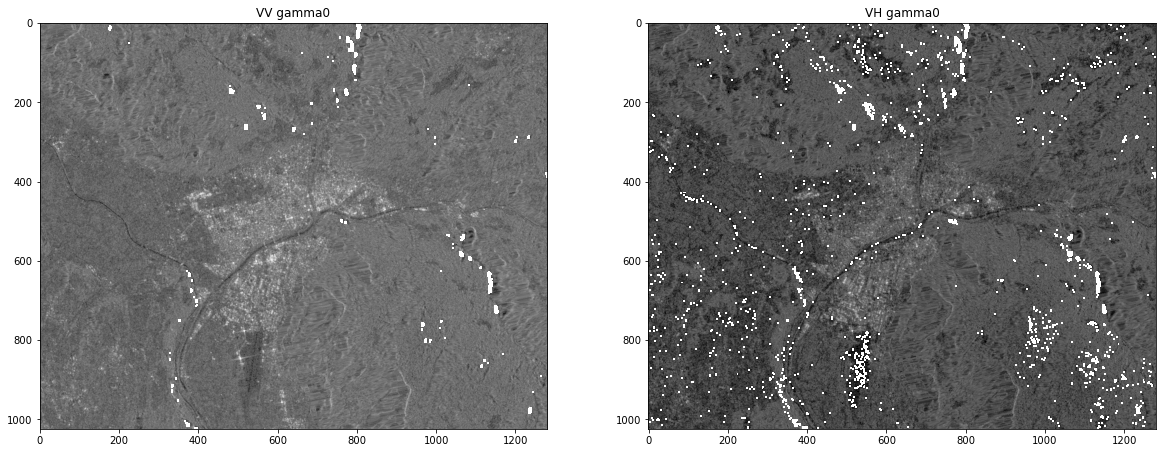

In [88]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(S1_ard.VV[0].values,cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('VV gamma0')
ax2.imshow(S1_ard.VH[0].values,cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('VH gamma0')
plt.show()

### Additional SAR processing capabilities:


The **sar_backscatter** process offer multiple parameters that can be used depending on the application needs: https://docs.openeo.cloud/processes/#sar_backscatter

We can choose among the following coefficients:
- **beta0**:            radar brightness
- **sigma0-ellipsoid**: ground area computed with ellipsoid earth model
- **sigma0-terrain**:   ground area computed with terrain earth model
- **gamma0-ellipsoid**: ground area computed with ellipsoid earth model in sensor line of sight
- **gamma0-terrain**:   ground area computed with terrain earth model in sensor line of sight (default)
- **null**:             non-normalized backscatter


###  CARD4L Compliant Surface Reflectance

**Pre-computed Sentinel-2 L2A with FORCE**

A precomputed FORCE L2A collection allows us to retrieve data quickly.

This dataset is limited in space and time, so will not work for any extent.

Let's have a look at the collection metadata:

In [44]:
conn.describe_collection("boa_sentinel_2")

{'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8a',
    'B11',
    'B12']},
  't': {'extent': ['2015-07-04T12:00:00+00:00', '2021-06-22T12:00:00+00:00'],
   'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [4600000.0, 5200000.0],
   'reference_system': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]',
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [1200000.0, 1700000.0],
   'reference_system': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]',
   'type': 'spatial'}},
 'deprecated': False,
 'description': 'Preprocessed analysis-read-data (ARD) from Sentinel-2',
 'extent': {'spatial': {'bbox': [[7.608756570103106,
     44.051614395910626,
     15.88359015576115,
     48.75515805343887]]},
  'temporal': {'interval': [['2015-07-04T12:00:00Z',
     '2021-06-22T12:00:00Z']]}},
 'id': 'boa_sentinel_2',
 'license': 'proprietary',
 'links': [{'href': 'http://doi.org/10.3390/rs11091124', 'rel': 'about'},
  {'href': 'http://doi.org/10.1016/j.rse.2018.04.046', 'rel': 'cloud'},
  {'href': 'https://doi.org/10.3390/rs13010137', 'rel': 'snow-ice'},
  {'href': 'https://doi.org/10.3390/rs13010137', 'rel': 'land-water'},
  {'href': 'http://doi.org/10.3390/rs10020352', 'rel': 'water-vapor'},
  {'href': 'https://doi.org/10.3390/rs13010137', 'rel': 'cloud-shadow'},
  {'href': 'https://ceos.org/ard/files/PFS/SR/v5.0/CARD4L_Product_Family_Specification_Surface_Reflectance-v5.0.pdf',
   'rel': 'card4l-document',
   'type': 'application/pdf'},
  {'href': 'https://spacedata.copernicus.eu/web/cscda/dataset-details?articleId=394198',
   'rel': 'elevation-model',
   'title': 'Copernicus DEM 30m'},
  {'href': 'http://doi.org/10.3390/rs10020352',
   'rel': 'atmospheric-scattering'},
  {'href': 'https://openeo.eodc.eu/v1.0/collections/boa_sentinel_2',
   'rel': 'self'},
  {'href': 'https://openeo.eodc.eu/v1.0/collections', 'rel': 'parent'},
  {'href': 'https://openeo.eodc.eu/v1.0/collections', 'rel': 'root'},
  {'href': 'https://openeo.eodc.eu/v1.0/collections/boa_sentinel_2/items',
   'rel': 'items'}],
 'stac_extensions': ['datacube', 'eo'],
 'stac_version': '1.0.0-beta',
 'summaries': {'constellation': ['sentinel-2'],
  'eo:bands': [{'center_wavelength': 0.489,
    'common_name': 'blue',
    'name': 'B02'},
   {'center_wavelength': 0.559, 'common_name': 'green', 'name': 'B03'},
   {'center_wavelength': 0.665, 'common_name': 'red', 'name': 'B04'},
   {'center_wavelength': 0.704, 'common_name': 'rededge', 'name': 'B05'},
   {'center_wavelength': 0.74, 'common_name': 'rededge', 'name': 'B06'},
   {'center_wavelength': 0.783, 'common_name': 'rededge', 'name': 'B07'},
   {'center_wavelength': 0.834, 'common_name': 'nir', 'name': 'B08'},
   {'center_wavelength': 0.865, 'common_name': 'nir08', 'name': 'B8a'},
   {'center_wavelength': 1.611, 'common_name': 'swir16', 'name': 'B11'},
   {'center_wavelength': 2.199, 'common_name': 'swir22', 'name': 'B12'}],
  'eo:gsd': [10.0],
  'instruments': ['msi'],
  'odc:file_format': ['GeoTIFF'],
  'odc:product_family': ['level2']},
 'title': 'BOA SENTINE

**1. Specify area of interest, temporal extent and bands:**

In [45]:
collection      = 'boa_sentinel_2'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2019-09-20", "2019-09-22"]
bands           = ["B02","B03","B04"]

s2 = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

**2. Save as NetCDF and start batch job:**

In [50]:
s2_netcdf = s2.save_result(format="NetCDF")

In [51]:
job_s2 = s2_netcdf.send_job(title="CARD4L_surface_reflectance")
job_id_s2 = job_s2.job_id
if job_id_s2:
    print("Batch job created with id: ",job_id_s2)
    job_s2.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  eodc-jb-e0546158-45d4-4614-bc20-75e162a4c0c3


We can get a description of the job and check its status.

In [55]:
job_s2 = conn.job(job_id_s2)
job_description = job_s2.describe_job()
print("Batch job with id: ",job_id_s2, ' is ',job_description['status'])

Batch job with id:  eodc-jb-e0546158-45d4-4614-bc20-75e162a4c0c3  is  finished


Once the status is 'finished' we can inspect the results. Download links are provided to retrieve data and metadata.

In [56]:
results = job_s2.get_results()
results

<JobResults for job 'eodc-jb-e0546158-45d4-4614-bc20-75e162a4c0c3'>

**2. Download the result:**

In [57]:
results.download_file("./data/card4l_s2.nc")

PosixPath('data/card4l_s2.nc')

**3. Output visualization**

In [58]:
S2_ard = xr.open_dataset("./data/card4l_s2.nc")
S2_ard

<xarray.Dataset>
Dimensions:      (t: 1, y: 876, x: 1030)
Coordinates:
  * t            (t) datetime64[ns] 2019-09-21T12:00:00
  * y            (y) float64 1.485e+06 1.485e+06 ... 1.476e+06 1.476e+06
  * x            (x) float64 4.863e+06 4.863e+06 ... 4.873e+06 4.873e+06
    spatial_ref  int32 ...
Data variables:
    B02          (t, y, x) float64 ...
    B03          (t, y, x) float64 ...
    B04          (t, y, x) float64 ...
Attributes:
    crs:      PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984"...
    nodata:   -9999

Text(0.5, 1.0, 'CARD4L S-2 Surface Reflectance - RGB Composite')

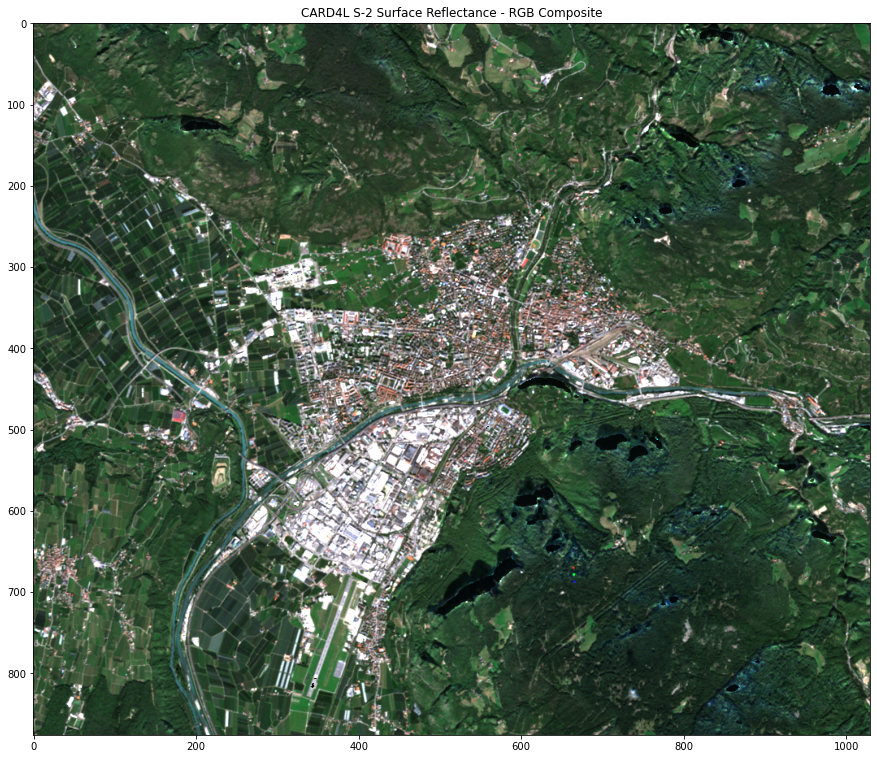

In [84]:
fig, ax1 = plt.subplots(1,1,figsize=(15,15))
ax1.imshow(tone_mapping(S2_ard.B04[0],S2_ard.B03[0],S2_ard.B02[0]))
ax1.set_title('CARD4L S-2 Surface Reflectance - RGB Composite')

**On-demand Sentinel-2 processing**

The **ard_surface_reflectance** process computes CARD4L compliant surface reflectance values from optical input.

More details here: https://docs.openeo.cloud/processes/#ard_surface_reflectance